In [1]:
import pandas as pd
from datetime import datetime
import yfinance as yf
from scipy.stats import linregress
import numpy as np
import ta
import os
import matplotlib.pyplot as plt

In [2]:
#get circuit limit data for stocks 
circuit_limit = pd.read_csv("F:\\Bot\\MomentumStrategy\\nifty500_price_bands.csv")
circuit_limit['stock_name'] = circuit_limit['stock_name'].str.strip()
print(circuit_limit.columns)

Index(['stock_name', 'price_band'], dtype='object')


In [3]:
def exponential_regression(x, y):
    #log of closing price
    log_y = np.log(y)

    #get slope, and r_value
    slope, intercept, r_value, _, _ = linregress(x, log_y)

    '''
    r**2 -> coefficient of determinent
    ranges from 0 - 1
    ''' 
    return slope, intercept, r_value**2 

In [4]:
def annualize_return(daily_slope):
    return ((np.exp(daily_slope) ** 250) - 1) * 100

In [5]:
def calculate_adjusted_return(df, ticker):
    '''
    returns -> list [ticker, slope, annualized_return, adjusted return]
    '''

    #getting last 90 days data
    x = np.arange(90)                   #list from 0-89
    y = df['close'].iloc[-90:].values   #last 90 closing prices


    slope, intercept, r2 = exponential_regression(x, y)
    annualized_return = annualize_return(slope)
    
    adjusted_return = annualized_return * r2
    

    return [ticker, slope, annualized_return, adjusted_return]

In [6]:
def check_circuits(df, upper_circuit=20, lower_circuit=20):
    '''
    hit -> if circuit was hit in the last 90 days
    freq -> frequency of circuit hits 
    '''

    hit = False
    freq = 0
    upper_circuit = int(upper_circuit) - 0.01
    lower_circuit = int(lower_circuit) - 0.01

    # Filtering the last 90 days data
    days_90 = df.iloc[-90:, :].copy()

    # Calculate the upper and lower circuit levels
    days_90.loc[:, 'upper_circuit'] = days_90['close'].shift(1) * (1 + upper_circuit / 100)
    days_90.loc[:, 'lower_circuit'] = days_90['close'].shift(1) * (1 - lower_circuit / 100)

    # Initialize the circuit columns 
    days_90['Hit Upper Circuit'] = False
    days_90['Hit Lower Circuit'] = False

    # Explicitly cast columns to bool dtype
    days_90['Hit Upper Circuit'] = days_90['Hit Upper Circuit'].astype(bool)
    days_90['Hit Lower Circuit'] = days_90['Hit Lower Circuit'].astype(bool)

   
    days_90.loc[days_90['high'] >= days_90['upper_circuit'], 'Hit Upper Circuit'] = True    
    days_90.loc[days_90['low'] <= days_90['lower_circuit'], 'Hit Lower Circuit'] = True

    # Count the number of hits for both upper and lower circuits
    upper_circuit_hits = days_90['Hit Upper Circuit'].sum()
    lower_circuit_hits = days_90['Hit Lower Circuit'].sum()
    freq = upper_circuit_hits + lower_circuit_hits

    # Determine if there were any hits
    if freq > 0:
        hit = True

    return hit, freq


In [7]:
def check_circuits_on_full_df(df, upper_circuit=20, lower_circuit=20):
    
    '''function only for simulation

    Returns two new columns:
    - circuit_hit_90d`: True/False if a circuit was hit in the last 90 days.
    - circuit_freq_90d`: The frequency of circuit hits in the last 90 days.'''
    
    circuit_hit_90d = []
    circuit_freq_90d = []

    for i in range(len(df)):
        if i < 90:
            # If we have less than 90 rows, use what we have
            sub_df = df.iloc[:i+1]
        else:
            # Otherwise, use the last 90 rows
            sub_df = df.iloc[i-89:i+1]

        hit, freq = check_circuits(sub_df, upper_circuit, lower_circuit)
        circuit_hit_90d.append(hit)
        circuit_freq_90d.append(freq)

    df['circuit_hit_90d'] = circuit_hit_90d
    df['circuit_freq_90d'] = circuit_freq_90d

    return df

In [8]:
def calculate_atr(df, window=14):
    atr = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=window)
    # Calculate RMA manually
    rma_atr = atr.average_true_range().ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    return rma_atr

In [9]:
def get_sma(df, window = 200):
    df.columns = [i.lower() for i in df.columns]
    #SMA calcluation
    df['sma_' + str(window)] = ta.trend.sma_indicator(df['close'], window=window)
    df['sma_' + str(window)+'_above'] = df['close'] > df['sma_' + str(window)] 
    return df

In [10]:
ticker = "^CRSLDX"

# Fetch the historical data
nifty500_data = yf.download(ticker, start="2022-01-01", end="2024-08-31")
print(nifty500_data.shape)
nifty500_data = get_sma(nifty500_data)
nifty500_stocks = pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
#filtering csv to EQ and getting only symbol column
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']
nifty500_data.to_csv('nifty500.csv')

nifty500_data = pd.read_csv('nifty500.csv')
nifty500_stocks= pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']


[*********************100%***********************]  1 of 1 completed

(653, 6)


In [11]:
nifty500_data.tail()

,Date,open,high,low,close,adj close,volume,sma_200,sma_200_above
648,2024-08-26,23514.300781,23579.750000,23466.750000,23561.750000,23561.750000,19994300,20502.214531,True
649,2024-08-27,23592.000000,23633.199219,23555.550781,23604.849609,23604.849609,22130300,20536.411533,True
650,2024-08-28,23646.800781,23679.349609,23547.250000,23615.949219,23615.949219,24488600,20570.360781,True
651,2024-08-29,23618.250000,23664.349609,23494.449219,23631.400391,23631.400391,29804300,20604.512285,True
652,2024-08-30,23728.550781,23766.400391,23673.949219,23734.550781,23734.550781,70150200,20639.520293,True


In [12]:
def get_positional_data(nifty500_stocks, 
                        specific_date = datetime.today().date() - pd.Timedelta(days = 1),  
                        num_periods = 400, path = 'F:\\Bot\\data dump\\outputs\\', 
                        account_value = 1000000,
                        risk_factor = 0.002):
    
    '''
    nifty500_stocks ->  list of stock names
    specific_date   ->  extract data till previous date
    numperiods      ->  number of datapoints (days) to be extracted from csv
    path            ->  path for csv file for stock data

    returns a filtered dataframe
    
    '''
    
    main_df = pd.DataFrame(columns=['stock_name', 'prev_close', 'slope', 'annualized_return', 'adjusted_return', 'prev_sma_100_above', 'circuit_hitted', 'circuit_freq', 'prev_atr_20'])


    for i in nifty500_stocks:
        try:
            
            data = pd.read_csv(path + i + '.csv')  # readin file
            data['Date'] = pd.to_datetime(data['Date']).dt.date  #converting to datetime columns
            
            # Filter data up to the specific date
            data = data[data['Date'] <= specific_date]
            
            # Select the last 400 data points
            data = data.iloc[-num_periods:]
            

            # If less than 400 data points, continue to next stock
            if len(data) < num_periods:
                continue

        except Exception as e:
            print(e)
            continue

        
        ''' 
        getting sma and circuit is repeated data, we already have that in csv file
        remove it later on
        
        '''
        # Getting sma
        data = get_sma(data, 100)

        # Circuit hit
        
        circuit = circuit_limit.loc[circuit_limit['stock_name'] == i, 'price_band'].values[0]
        #print(i, circuit)
        if not circuit:
            hit, freq = check_circuits(data, 
                                    upper_circuit = circuit, 
                                    lower_circuit = circuit)
        else:
            hit, freq = check_circuits(data)
        
        # Getting atr
        data['atr_20'] = calculate_atr(data, 20)
        
        
        
        # Getting slope, annualized return, adjusted_return
        l = calculate_adjusted_return(data, i)
        new_row = {
            'stock_name': l[0],
            'prev_close': data['close'].iloc[-1],
            'slope': l[1],
            'annualized_return': l[2],
            'adjusted_return': l[3],
            'prev_sma_100_above': data['sma_100_above'].iloc[-1],
            'circuit_hitted': hit,
            'circuit_freq': freq,
            'prev_atr_20': data['atr_20'].iloc[-1]
        }
        
        # Adding to dataframe
        main_df.loc[len(main_df.index)] = new_row
    

    filtered_df = main_df.sort_values(by='adjusted_return', ascending=False)
    
    account_value = 1000000
    risk_factor = 0.002

    #filtering
    filtered_df['no_of_shares'] = [account_value * risk_factor]/filtered_df['prev_atr_20']
    filtered_df['no_of_shares'] = filtered_df['no_of_shares'].astype(int)
    
    

    #checking till our cumulative cash reached close to account value
    filtered_df['invested_amount'] = filtered_df['no_of_shares'] * filtered_df['prev_close']
    filtered_df['cumulative_invested_amount'] = filtered_df['invested_amount'].cumsum()

    
    return filtered_df

In [13]:
def get_and_save_positional_data(nifty500_stocks, specific_date):
    # Define the filename based on the specific date
    filename = f"positions_{specific_date}.csv"
    filepath = os.path.join("F:\Bot\MomentumStrategy\positionalData", filename)

    # Check if the file already exists
    if os.path.exists(filepath):
        print(f"File {filename} already exists. Loading existing data.")
        position_data = pd.read_csv(filepath)
    else:
        # Generate the positional data
        position_data = get_positional_data(nifty500_stocks, specific_date)
        
        # Save to CSV
        position_data.to_csv(filepath, index=False)
        print(f"Positional data saved to {filename}.")

    return position_data

In [14]:
def preprocess(df, stock_name):
    #getting circuits
    circuit = circuit_limit.loc[circuit_limit['stock_name'] == stock_name, 'price_band'].values[0]
    if not circuit:
            df = check_circuits_on_full_df(df, 
                                    upper_circuit = circuit, 
                                    lower_circuit = circuit)
    else:
        df = check_circuits_on_full_df(df)

    #getting sma

    df = get_sma(df, 100)
    return df

In [15]:
data_dict = {}

In [16]:
initial_cash = 1000000  # Example starting cash
risk_factor = 0.002
cash_in_hand = initial_cash
portfolio = {} 

In [17]:
def simulate(start_date, end_date, nifty500_data):
    
    global cash_in_hand, portfolio
    
    equity = []
    dates = []

    nifty500_data['Date'] = pd.to_datetime(nifty500_data['Date'])
    current_date = start_date

    start_day_weekday = start_date.weekday()  # Store the start date's weekday

    while current_date <= end_date:
        print(current_date)
        # Daily exit condition check
        stock_to_exit = []
        for stock in portfolio:
            try:
                # Load the latest data for the stock
                stock_df = data_dict[stock]
                sma_100 = stock_df.loc[stock_df['Date'] < current_date, 'sma_100_above'].values[-1]
                circuit_check = stock_df.loc[stock_df['Date'] <= current_date, 'circuit_hit_90d'].values[-1]
                
                # Exit conditions
                if not sma_100:
                    print(stock, 'below SMA')
                    stock_to_exit.append(stock)
                
                elif circuit_check:
                    print(stock, 'circuit hit')

                    stock_to_exit.append(stock)
                    
            except Exception as e:
                print(f"Error checking exit conditions for {stock}: {e}")
                stock_to_exit.append(stock)
            
        # Exiting stocks and adding to cash in hand
        for stock in stock_to_exit:
            #we will sell on opening of next day
            sell_price = data_dict[stock].loc[data_dict[stock]['Date'] > current_date, 'open'].values[0]


            exit_amount = sell_price * portfolio[stock]['shares']
            cash_in_hand += exit_amount
            print(f'Sold {stock} at {sell_price} on {current_date + pd.Timedelta(days = 1)}, realized gain: {exit_amount - portfolio[stock]["invested_amount"]}')
            del portfolio[stock]

        # Check if it's the start day's weekday (weekly rebalancing and buying)
        if current_date.weekday() == start_day_weekday:
            positional_data = get_and_save_positional_data(nifty500_stocks, current_date)


            #rank based exit
            
            positional_data['rank'] = positional_data['stock_name'].rank(method='first')
            for stock in list(portfolio.keys()):
                
                stock_rank = positional_data.loc[positional_data['stock_name'] == stock, 'rank'].values[0]
                if stock_rank > 75:
                    sell_price = data_dict[stock].loc[data_dict[stock]['Date'] >= current_date, 'open'].values[0] #exiting on current day opening as weekly is checked before market hours
                    exit_amount = sell_price * portfolio[stock]['shares']
                    cash_in_hand += exit_amount
                    print(f'Sold {stock} at {sell_price} on {current_date + pd.Timedelta(days=1)} due to rank {stock_rank}, realized gain: {exit_amount - portfolio[stock]["invested_amount"]}')
                    del portfolio[stock]

            # Rebalancing: Reducing shares
            for i, row in positional_data.iterrows():
                if row['stock_name'] in portfolio:
                    current_shares = portfolio[row['stock_name']]['shares']
                    new_shares = row['no_of_shares']

                    if abs(new_shares - current_shares) / current_shares > 0.05 and current_shares > new_shares:
                        shares_to_sell = current_shares - new_shares
                        sell_price = data_dict[row['stock_name']].loc[data_dict[row['stock_name']]['Date'] >= current_date, 'open'].values[0]
                        sell_amount = shares_to_sell * sell_price

                        portfolio[row['stock_name']]['shares'] = new_shares
                        portfolio[row['stock_name']]['invested_amount'] -= sell_amount
                        cash_in_hand += sell_amount
                        print(f'Reduced {row["stock_name"]} to {new_shares} shares on {current_date}')

            # Rebalancing: Adding shares
            for i, row in positional_data.iterrows():
                if row['stock_name'] in portfolio:
                    current_shares = portfolio[row['stock_name']]['shares']
                    new_shares = row['no_of_shares']

                    if new_shares > current_shares and abs(new_shares - current_shares) / current_shares > 0.05:
                        shares_to_buy = new_shares - current_shares
                        buy_price = data_dict[row['stock_name']].loc[data_dict[row['stock_name']]['Date'] >= current_date, 'open'].values[0]
                        buy_amount = shares_to_buy * buy_price

                        if cash_in_hand >= buy_amount:
                            portfolio[row['stock_name']]['shares'] += shares_to_buy
                            portfolio[row['stock_name']]['invested_amount'] += buy_amount
                            cash_in_hand -= buy_amount
                            print(f'Increased {row["stock_name"]} to {portfolio[row["stock_name"]]["shares"]} shares on {current_date}')

            # Buying new stocks
            for i, row in positional_data.iterrows():
                if row['stock_name'] not in portfolio:
                    if (
                        row['prev_sma_100_above'] 
                        and not row['circuit_hitted'] 
                        and row['no_of_shares'] != 0
                        and cash_in_hand > row['invested_amount'] 
                        and nifty500_data.loc[nifty500_data['Date'].dt.date <= current_date, 'sma_200_above'].values[-1]
                    ):
                        stock_df = data_dict.get(row['stock_name'], pd.read_csv("F:\\Bot\\data dump\\outputs\\" + row['stock_name'] + '.csv'))
                        stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
                        data_dict[row['stock_name']] = stock_df

                        current_opening_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]
                        portfolio[row['stock_name']] = {
                            'entry_date': current_date,
                            'shares': row['no_of_shares'],
                            'invested_amount': row['no_of_shares'] * current_opening_price
                        }
                        cash_in_hand -= portfolio[row['stock_name']]['invested_amount']
                        print(f'Bought {row["stock_name"]} on {current_date} at {current_opening_price} no of share : {row["no_of_shares"]}')
        
        # Calculating equity
        equity_value = sum(
            portfolio[stock]['shares'] * data_dict[stock].loc[data_dict[stock]['Date'] >= current_date, 'close'].values[0]
            for stock in portfolio
        ) + cash_in_hand
        equity.append(equity_value)
        dates.append(current_date)

        current_date += pd.Timedelta(days=1)

    return equity, dates


In [18]:
start_date = datetime(2023, 1, 1).date()
end_date = datetime(2024, 8, 30).date()

equity, dates = simulate(start_date, end_date, nifty500_data)

2023-01-01
File positions_2023-01-01.csv already exists. Loading existing data.
Bought RVNL on 2023-01-01 at 68.25 no of share : 608
Bought MAZDOCK on 2023-01-01 at 798.0 no of share : 50
Bought UNIONBANK on 2023-01-01 at 80.9 no of share : 563
Bought BANKINDIA on 2023-01-01 at 88.95 no of share : 524
Bought GODFRYPHLP on 2023-01-01 at 1986.0 no of share : 27
Bought J&KBANK on 2023-01-01 at 56.9 no of share : 759
Bought MAHABANK on 2023-01-01 at 30.85 no of share : 1342
Bought JSL on 2023-01-01 at 241.0 no of share : 254
Bought CENTRALBK on 2023-01-01 at 32.4 no of share : 1217
Bought COCHINSHIP on 2023-01-01 at 265.48 no of share : 141
Bought IOB on 2023-01-01 at 32.4 no of share : 1342
Bought INDIANB on 2023-01-01 at 287.0 no of share : 190
Bought GRSE on 2023-01-01 at 487.0 no of share : 77
Bought JKLAKSHMI on 2023-01-01 at 822.55 no of share : 67
Bought PNB on 2023-01-01 at 56.8 no of share : 994
Bought IRCON on 2023-01-01 at 60.0 no of share : 703
Bought IRFC on 2023-01-01 at 32.7

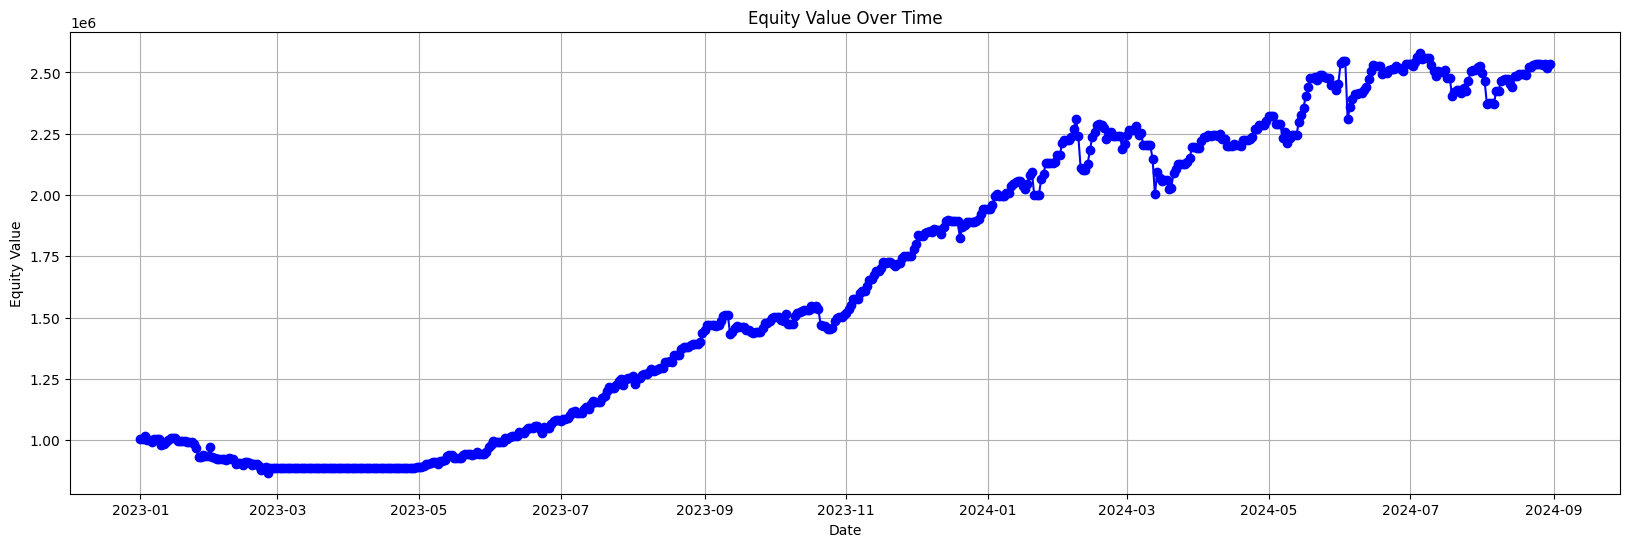

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(dates,equity, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Equity Value Over Time')
plt.grid(True)
plt.show()

In [20]:
for i, j in zip(dates, equity):
    print(i, j)

2023-01-01 1005272.2999999999
2023-01-02 1005272.2999999999
2023-01-03 1016472.95
2023-01-04 1000422.5800000001
2023-01-05 1000962.62
2023-01-06 992323.3900000002
2023-01-07 1004181.28
2023-01-08 1004356.8299999998
2023-01-09 1004356.8299999998
2023-01-10 981068.9299999998
2023-01-11 986495.1899999998
2023-01-12 992779.5299999999
2023-01-13 1002254.3
2023-01-14 1009832.1599999997
2023-01-15 1007355.0499999998
2023-01-16 1007355.0499999998
2023-01-17 995088.3499999997
2023-01-18 998600.3999999997
2023-01-19 995453.0999999997
2023-01-20 996959.9999999997
2023-01-21 994367.4999999995
2023-01-22 993962.1499999996
2023-01-23 993962.1499999996
2023-01-24 983969.7499999995
2023-01-25 967437.2999999996
2023-01-26 930522.0999999995
2023-01-27 930522.0999999995
2023-01-28 940807.2999999995
2023-01-29 935531.4899999993
2023-01-30 935531.4899999993
2023-01-31 972224.4499999991
2023-02-01 930478.8699999993
2023-02-02 928915.999999999
2023-02-03 923604.2899999992
2023-02-04 922441.6599999991
2023-02